In [250]:
import fasttext
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import os
import random
from itertools import combinations, product
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Input, Dropout, Lambda, Concatenate, GRU
from tensorflow.keras.regularizers import l2

# Have to download the stopwords
# nltk.download('stopwords')

In [2]:
# Get the fasttext model (we are using the largest one they offer [600B tokens])
fasttext_model = fasttext.load_model('models/crawl-300d-2M-subword.bin')

## General Useful Function
Functions that are continually used throughout this project

In [3]:
"""
Definitions of some sizes in the training set
"""
MAX_LEN = 45
EMBEDDING_SHAPE = (300,)
print('MAX_LEN: ' + str(MAX_LEN), 'EMBEDDING_SHAPE: ' + str(EMBEDDING_SHAPE))

MAX_LEN: 45 EMBEDDING_SHAPE: (300,)


In [4]:
def get_max_len(df):
    max_len = 0
    for row in df.itertuples():
        if len(row.title_one.split(' ')) > max_len:
            max_len = len(row.title_one.split(' '))
            
        if len(row.title_two.split(' ')) > max_len:
            max_len = len(row.title_two.split(' '))
    
    return max_len

In [5]:
def print_dataframe(df):
    for idx in range(len(df)):
        print(df.iloc[idx].title_one + '\n' + df.iloc[idx].title_two)
        print('________________________________________________________________')

In [6]:
def create_final_data(pos_df, neg_df):
    pos_df = pos_df.sample(frac=1)
    neg_df = neg_df.sample(frac=1)
    final_df = pd.concat([pos_df[:min(len(pos_df), len(neg_df))], neg_df[:min(len(pos_df), len(neg_df))]])
    final_df = final_df.sample(frac=1)
    return final_df

In [7]:
def remove_stop_words(phrase):
    # Creates the stopwords
    to_stop = stopwords.words('english')
    to_stop.remove('m')
    punctuation = "!”#$%&’()*+,-./:;<=>?@[\]^_`{|}~ \""
    for c in punctuation:
        to_stop.append(c)

    to_stop.append('null')
    
    for punc in punctuation:
        phrase = phrase.replace(punc, ' ')
    
    return ' '.join((' '.join([x for x in phrase.split(' ') if x not in to_stop])).split()).lower()


In [8]:
# Drop the Unnamed: 0 column and drop any row where it is all NaN
def remove_misc(df):
    columns = list(df.columns)[1:]
    df = df.drop(columns=['Unnamed: 0'])
    df = df.dropna(how='all')
    return df


## Data Processsing and Organization
Here, all we really want to do is prepare the data for training. This is **only** the data from **Gold Standard** This includes:
* Simplifying the original data
* Normalizing the data 
* Balancing the positive and negative examples
* Creating the embedding representations that will actually get fed into the neural network

In [153]:
# Organizing and normalizing the data
"""
Essentially, we want to only have three attributes for each training example: title_one, title_two, label
For normalization, we are just going to use the nltk stopwords and punctuation
"""

def preprocessing(orig_data):
    """
    Normalizes the data by getting rid of stopwords and punctuation
    """
    
    # The new names of the columns
    column_names = ['title_one', 'title_two', 'label']
    # A new dataframe for the data we are going to be creating
    norm_data = pd.DataFrame(columns = column_names)
    # Iterate over the original dataframe (I know it is slow and there are probably better ways to do it)
    iloc_data = orig_data.iloc
    for idx in tqdm(range(len(orig_data))):
        row = iloc_data[idx]
        title_left = remove_stop_words(row.title_left)
        title_right = remove_stop_words(row.title_right)
        
        # Append the newly created row (title_left, title_right, label) to the new dataframe
        norm_data = norm_data.append(pd.DataFrame([[title_left, title_right, row.label]], columns=column_names))
    
    return norm_data
        

In [154]:
def create_train_df(df):
    """
    Returns a shuffled dataframe with an equal amount of positive and negative examples
    """
    # Get the positive and negative examples
    pos_df = df.loc[df['label'] == 1]
    neg_df = df.loc[df['label'] == 0]
    
    # Shuffle the data
    pos_df = pos_df.sample(frac=1)
    neg_df = neg_df.sample(frac=1)
    
    # Concatenate the positive and negative examples and 
    # make sure there are only as many negative examples as positive examples
    final_df = pd.concat([pos_df[:min(len(pos_df), len(neg_df))], neg_df[:min(len(pos_df), len(neg_df))]])
    
    # Shuffle the final data once again
    final_df.sample(frac=1)
    
    return final_df

In [155]:
def create_training_data(df, path):
    """
    Creates and saves a simpler version of the original data that only contains the the two titles and the label.
    """
    
    norm_bal_data = create_train_df(preprocessing(df))
    
    # Save the new normalized and simplified data to a CSV file to load later
    norm_bal_data.to_csv(path, index=False)

In [156]:
# Load the data
computer_df = pd.read_json('data/train/computers_train_xlarge_normalized.json.gz', compression='gzip', lines=True)

In [157]:
# See some of the data. There is clearly a separation between the positive and negative examples
computer_df

,id_left,title_left,description_left,brand_left,price_left,specTableContent_left,keyValuePairs_left,category_left,cluster_id_left,identifiers_left,...,description_right,brand_right,price_right,specTableContent_right,keyValuePairs_right,category_right,cluster_id_right,identifiers_right,label,pair_id
0,5490217,hp intel xeon x5560 prijzen tweakers,None,None,None,categorie processors merk hp product hp intel ...,"{'categorie': 'processors', 'merk': 'hp', 'pro...",Computers_and_Accessories,1679624,"[{'/mpn': '[495906b21]'}, {'/gtin13': '[884420...",...,description intel xeon x5560 ml350 g6 2 80ghz ...,hp enterprise,usd 213 85,specifications category proliant processor sub...,"{'category': 'proliant processor', 'sub catego...",Computers_and_Accessories,1679624,[{'/mpn': '[495906b21]'}],1,5490217#16248399
1,16876009,"495906 b21 hp x5560 2 80ghz ml350 g6 , null ne...",description intel xeon x5560 ml350 g6 2 80ghz ...,hp enterprise,None,specifications category proliant processor sub...,"{'category': 'proliant processor', 'sub catego...",Computers_and_Accessories,1679624,"[{'/sku': '[495906b21]'}, {'/mpn': '[495906b21...",...,description intel xeon x5560 ml350 g6 2 80ghz ...,hp enterprise,usd 213 85,specifications category proliant processor sub...,"{'category': 'proliant processor', 'sub catego...",Computers_and_Accessories,1679624,[{'/mpn': '[495906b21]'}],1,16876009#16248399
2,16543750,asus motherboard lga2066 ddr4 m 2 u atx 2xgbe ...,None,None,None,None,None,Computers_and_Accessories,109916,"[{'/sku': '[34181655]'}, {'/mpn': '[primex299d...",...,placa base atx socket lga2066 chipset intel x2...,None,None,None,None,Computers_and_Accessories,109916,[{'/productID': '[90mb0ty0m0eay0]'}],1,16543750#14031864
3,16721450,asus prime x299 deluxe prijzen tweakers,None,None,None,categorie moederborden merk asus product asus ...,"{'categorie': 'moederborden', 'merk': 'asus', ...",Computers_and_Accessories,109916,"[{'/mpn': '[primex299deluxe, 90mb0ty0m0eay0]'...",...,support for x series intel core processors sli...,asus,None,None,None,Computers_and_Accessories,109916,"[{'/mpn': '[90mb0ty0m0eay0]'}, {'/gtin13': '[4...",1,16721450#10358026
4,14031864,asus prime x299 deluxe,placa base atx socket lga2066 chipset intel x2...,None,None,None,None,Computers_and_Accessories,109916,[{'/productID': '[90mb0ty0m0eay0]'}],...,atx quad channel ddr4 3 x pcie 3 0 x16 2 x m 2...,asus,None,None,None,Computers_and_Accessories,109916,"[{'/productID': '[asux29del]'}, {'/mpn': '[pri...",1,14031864#4588573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68456,11523636,seagate barracuda es 2 st3750330ns 750gb 3 5 h...,None,seagate,None,None,None,Computers_and_Accessories,987859,[{'/mpn': '[st3750330ns]'}],...,description 10 x 500gb hot plug serial ata sat...,hp enterprise,None,specifications category proliant harddrive sub...,"{'category': 'proliant harddrive', 'sub catego...",Computers_and_Accessories,2516582,"[{'/sku': '[45414100210pack]'}, {'/mpn': '[454...",0,11523636#13889537
68457,16852097,seagate barracuda es 2 750gb sata ii 32mb cach...,750gb capacity sata ii interface 7200rpm spin ...,seagate,None,None,None,Computers_and_Accessories,987859,[{'/mpn': '[st3750330ns]'}],...,description hp 6tb 3 5 inch lff serial attache...,hp enterprise,None,specifications category proliant harddrive sub...,"{'category': 'proliant harddrive', 'sub catego...",Computers_and_Accessories,12211572,"[{'/sku': '[782995001]'}, {'/mpn': '[782995001...",0,16852097#16101389
68458,11002668,"null , st3750330ns seagate 750 gb 15k 3 5 3g sata",description 2 x seagate barracuda 750gb non ho...,seagate,cad 298 87 cad,specifications category seagate harddrive sub ...,"{'category': 'seagate harddrive', 'sub categor...",Computers_and_Accessories,987859,[{'/mpn': '[st3750330ns]'}],...,the one drive for every desktop system need su...,seagate,us 46 99,official release date sep 30 2011 genre hard d...,"{'official release date': 'sep 30 2011', 'genr...",Computers_a

In [158]:
# Create and save the data if the simple and normalized data does not exist
computer_data_path = 'data/train/computers_train_bal_shuffle.csv'

# If the computer data has not been made yet, make it
if not os.path.exists(computer_data_path):
    create_training_data(computer_df, computer_data_path)

100%|██████████| 68461/68461 [07:42<00:00, 147.91it/s]


In [ ]:
# Load cameras data
camera_df = pd.read_json('data/train/cameras_train_xlarge_normalized.json.gz', compression='gzip', lines=True)

In [ ]:
camera_df

In [ ]:
# Create and save the data if the simple and normalized data does not exist
camera_data_path = 'data/train/cameras_train_bal_shuffle.csv'

# If the computer data has not been made yet, make it
if not os.path.exists(camera_data_path):
    create_training_data(camera_df, camera_data_path)

In [7]:
final_computer_df = pd.read_csv('data/train/computers_train_bal_shuffle.csv')

In [88]:
final_computer_df = final_computer_df.sample(frac=1)

In [89]:
final_computer_df

,title_one,title_two,label
14087,crucial 4gb pc3 12800 204 pin ddr3 sdram sodim...,ddr3 kingston value 8go 1600 mhz 2x4,0
2561,amd ryzen 5 1600x boxed zonder koeler prijzen ...,amd ryzen 5 1600x six core processor without c...,1
7111,amd athlon x4 860k 3 7 ghz black low noise edi...,amd athlon x4 860k 3 7ghz quad core processor ...,1
14074,fire tablet 7 display wi fi 8 gb includes spec...,amazon fire hd 8 16gb 6th gen 2016 release black,0
2699,hp 300876 b21 proliant bl20p g2,300876 b21 bl20p g2 xeon 2 8ghz 512 1p,1
...,...,...,...
4455,16gb 2133mh ddr4cl14 dimm furyblack tradineur com,kingston hyperx fury black hx421c14fb2k2 16 pr...,1
7304,432094 b21 hp 146 gb 15k 3 5 sp sas 2 pack par...,432094 b21 hp 146 gb 15k 3 5 sp sas new pack w...,1
15357,gigabyte z370m d3h intel z370 socket 1151 ddr4...,asus prime b250m plus intel b250 socket 1151 d...,0
18292,dell ultrasharp u2414h 23 8 full hd ips monito...,kingston valueram ddr4 16 gb 2 x 8 dimm 288 pi...,0


In [ ]:
final_camera_df = pd.read_csv('data/train/cameras_train_bal_shuffle.csv')

In [ ]:
final_camera_df

## Laptop Data Preprocessing
* Normalize the data
* Create negative examples that represent when only a couple of attributes of the laptop data changes

In [65]:
# Load the laptop data
laptop_df = pd.read_csv('data/train/laptops.csv', encoding='latin-1')

In [66]:
laptop_df

,Unnamed: 0,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,1316,Lenovo,Yoga 500-14ISK,2 in 1 Convertible,14.0,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 6500U 2.5GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.8kg,638.00
1299,1317,Lenovo,Yoga 900-13ISK,2 in 1 Convertible,13.3,IPS Panel Quad HD+ / Touchscreen 3200x1800,Intel Core i7 6500U 2.5GHz,16GB,512GB SSD,Intel HD Graphics 520,Windows 10,1.3kg,1499.00
1300,1318,Lenovo,IdeaPad 100S-14IBR,Notebook,14.0,1366x768,Intel Celeron Dual Core N3050 1.6GHz,2GB,64GB Flash Storage,Intel HD Graphics,Windows 10,1.5kg,229.00
1301,1319,HP,15-AC110nv (i7-6500U/6GB/1TB/Radeon,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,6GB,1TB HDD,AMD Radeon R5 M330,Windows 10,2.19kg,764.00


In [67]:
# This class will be used in order to exchange the different attributes
# to create negative examples
class LaptopAttributes():
    company = {'Apple'}
    product = {'MacBook Pro'}
    inches = {'13.3'}
    cpu = {'Intel Core i5 2.3GHz'}
    ram = {'4GB'}
    memory = {'256GB SSD'}
    gpu = {'Intel HD Graphics 520'}
    screen = {'1440x900'}
    
    def get_all_data():
        return {
            'company': LaptopAttributes.company,
            'product': LaptopAttributes.product,
            'inches': LaptopAttributes.inches,
            'cpu': LaptopAttributes.cpu,
            'ram': LaptopAttributes.ram,
            'memory': LaptopAttributes.memory,
            'gpu': LaptopAttributes.gpu,
            'screen': LaptopAttributes.screen
        }

In [68]:
# Create attribute sets
def create_attribute_sets(df):
    LaptopAttributes.company.update([row.Company for row in laptop_df[['Company']].itertuples()])
    LaptopAttributes.product.update([row.Product for row in laptop_df[['Product']].itertuples()])
    LaptopAttributes.inches.update([str(row.Inches) for row in laptop_df[['Inches']].itertuples()])
    LaptopAttributes.cpu.update([row.Cpu for row in laptop_df[['Cpu']].itertuples()])
    LaptopAttributes.ram.update([row.Ram for row in laptop_df[['Ram']].itertuples()])
    LaptopAttributes.memory.update([row.Memory for row in laptop_df[['Memory']].itertuples()])
    LaptopAttributes.gpu.update([row.Gpu for row in laptop_df[['Gpu']].itertuples()])
    LaptopAttributes.screen.update([row.ScreenResolution for row in laptop_df[['ScreenResolution']].itertuples()])

create_attribute_sets(laptop_df)

In [69]:
def concatenate_row(row):
    # Note: got rid of everything after the '(' because it has info about the actual specs of the laptop
    # so if we change the specs, we need to fix that too
    
    # Special tags at the end of the amount of inches of the laptop and the RAM to simulate real data
    inch_attr = str(row['Inches']) + random.choice([' inch', '', '"'])
    ram_attr = row['Ram'] + random.choice([' ram', ' memory', ''])
    
    # These are words that commonly come up with laptops
    modifiers = ['premium', 'new', 'fast', 'latest model']
    add_ins = ['USB 3.0', 'USB 3.1 Type-C', 'USB Type-C', 'Bluetooth', 'WIFI', 'Webcam', 'FP Reader',
               'HDMI', '802.11ac', '802.11 ac', 'home', 'flagship', 'business', 'GbE LAN', 'DVD-RW', 'DVD', 'Windows 10']
    
    cpu_attr = row['Cpu']
    if random.choice([0, 1]):
        cpu_attr = cpu_attr.split(' ')
        if random.choice([0, 1]):
            if 'Intel' in cpu_attr:
                cpu_attr.remove('Intel')
        if random.choice([0, 1]):
            if 'Core' in cpu_attr:
                cpu_attr.remove('Core')
        if random.choice([0, 1]):
            if 'AMD' in cpu_attr:
                cpu_attr.remove('AMD')
    
        cpu_attr = ' '.join(cpu_attr)

    # Create a list for all the product attributes
    order_attrs = [random.choice(modifiers),
                   row['Company'],
                   row['Product'].split('(')[0],
                   row['TypeName'],
                   inch_attr,
                   row['ScreenResolution'],
                   cpu_attr,
                   ram_attr,
                   row['Memory'],
                   row['Gpu']]
    
    order_attrs = order_attrs + random.sample(add_ins, random.choice([1, 2, 3, 4]))
    
    # Shuffle the data because in real data, it does not really matter what order the attributes are in
    random.shuffle(order_attrs)
    
    return ' '.join(order_attrs)

In [70]:
# Creates the negative examples for the laptop data
# The laptop_df is the original data, the new_df is the dataframe to append the new data to
# and the attributes are the attributes to swap for the new data
def create_neg_laptop_data(laptop_df, attributes):
    new_column_names = ['title_one', 'title_two', 'label']
    negative_df =pd.DataFrame(columns=new_column_names)
    temp = []
    for row in tqdm(range(len(laptop_df))):
        # Create a copy of the row for the negative example
        neg_row = laptop_df.iloc[row]
        for attribute_class in attributes:
            # Get the row in the laptop_data
            orig_row = laptop_df.iloc[row]
            
            # Get the attribute that we are trying to change
            attribute_val = orig_row[attribute_class]
            
            # Temporarily value for the new value
            new_val = attribute_val
            
            # Make sure we really get a new attribute
            while new_val == attribute_val:
                new_val = random.sample(LaptopAttributes.get_all_data()[attribute_class.lower()], 1)[0]
            
            # Change the value in the neg_row to the new value
            neg_row[attribute_class] = new_val
            
            # Concatenate and normalize the data
            title_one = remove_stop_words(concatenate_row(orig_row).lower())
            title_two = remove_stop_words(concatenate_row(neg_row).lower())
            
            # Append the data to the new df
            temp.append([title_one, title_two, 0])

    negative_df = negative_df.append(pd.DataFrame(temp, columns=new_column_names))    
    return negative_df

In [71]:
neg_df = create_neg_laptop_data(laptop_df, attributes=['Cpu', 'Memory', 'Ram', 'Inches', 'Product'])

  0%|          | 0/1303 [00:00<?, ?it/s]/home/jason/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 1303/1303 [00:04<00:00, 294.32it/s]


In [ ]:
print_dataframe(neg_df)

In [72]:
neg_df

,title_one,title_two,label
0,intel iris plus graphics 640 macbook pro 13 3 ...,macbook pro ips panel retina display 2560x1600...,0
1,fp reader webcam 13 3 128gb ssd 8gb memory int...,premium 8gb memory macbook pro dvd rw apple 1 ...,0
2,13 3 inch ultrabook macbook pro core i5 2 3ghz...,intel iris plus graphics 640 apple 4gb memory ...,0
3,8gb ram premium apple ips panel retina display...,13 9 inch ultrabook intel iris plus graphics 6...,0
4,core i5 2 3ghz flagship ultrabook apple 8gb 12...,ips panel retina display 2560x1600 13 9 usb ty...,0
...,...,...,...
6510,home intel celeron dual core n3050 1 6ghz 1366...,4gb ram hdmi x553sa xx031t intel hd graphics 5...,0
6511,asus x553sa xx031t notebook fast celeron dual ...,1366x768 notebook intel hd graphics 15 6 intel...,0
6512,intel celeron dual core n3050 1 6ghz asus new ...,usb type c webcam premium atom x5 z8350 1 44gh...,0
6513,asus 1366x768 intel hd graphics x553sa xx031t ...,business 1366x768 intel hd graphics intel atom...,0


In [80]:
# Creates the postive examples for the laptop data
# The laptop_df is the original data, the new_df is the dataframe to append the new data to
# and the attributes are the attributes to swap or delete for the new data
def create_pos_laptop_data(laptop_df, rm_attrs, add_attrs):
    new_column_names = ['title_one', 'title_two', 'label']
    pos_df = pd.DataFrame(columns = new_column_names)
    temp = []
    for row in tqdm(range(len(laptop_df))):
        # Remove the attribute from the new title
        for attr_list in rm_attrs:
            # Create a copy of the row for the negative example
            new_row = laptop_df.iloc[row]
            orig_row = laptop_df.iloc[row]
            for attr in attr_list:
                new_row[attr] = ''
        
            title_one = remove_stop_words(concatenate_row(orig_row).lower())
            title_two = remove_stop_words(concatenate_row(new_row).lower())
            
            temp.append([title_one, title_two, 1])
    
    pos_df = pos_df.append(pd.DataFrame(temp, columns=new_column_names))
    return pos_df

In [81]:
pos_df = create_pos_laptop_data(laptop_df, rm_attrs = [['Company'], ['TypeName'], ['ScreenResolution'], ['Product'], ['TypeName', 'ScreenResolution']], add_attrs = [])

  0%|          | 0/1303 [00:00<?, ?it/s]/home/jason/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
100%|██████████| 1303/1303 [00:04<00:00, 261.77it/s]


In [ ]:
print_dataframe(pos_df)

In [82]:
pos_df

,title_one,title_two,label
0,hdmi macbook pro apple 128gb ssd premium 13 3 ...,802 11ac macbook pro 8gb memory premium core i...,1
1,ips panel retina display 2560x1600 128gb ssd a...,ips panel retina display 2560x1600 128gb ssd n...,1
2,ips panel retina display 2560x1600 macbook pro...,intel iris plus graphics 640 ultrabook 13 3 ap...,1
3,13 3 inch apple ips panel retina display 2560x...,ultrabook apple 128gb ssd premium wifi intel i...,1
4,apple ultrabook premium 128gb ssd 13 3 ips pan...,apple windows 10 13 3 128gb ssd fast macbook p...,1
...,...,...,...
6510,intel celeron dual core n3050 1 6ghz 802 11ac ...,notebook 15 6 intel hd graphics x553sa xx031t ...,1
6511,notebook x553sa xx031t intel hd graphics 1366x...,15 6 inch intel hd graphics asus 4gb ram 500gb...,1
6512,asus intel celeron dual core n3050 1 6ghz inte...,4gb memory fast asus 15 6 dvd intel hd graphic...,1
6513,intel hd graphics 500gb hdd 1366x768 4gb memor...,4gb intel hd graphics bluetooth gbe lan latest...,1


In [83]:
final_laptop_df = create_final_data(pos_df, neg_df)

In [84]:
final_laptop_df = final_laptop_df.sample(frac=1)

In [85]:
final_laptop_df

,title_one,title_two,label
2640,notebook 15 6 inspiron 3567 dell latest model ...,500gb hdd notebook inspiron 3567 4gb memory in...,1
5621,latest model intel core i3 7100u 2 4ghz intel ...,4gb ram core i3 7100u 2 4ghz asus 1366x768 gbe...,1
6512,asus intel celeron dual core n3050 1 6ghz inte...,4gb memory fast asus 15 6 dvd intel hd graphic...,1
4145,acer gbe lan dvd dvd rw 128gb ssd bluetooth 8g...,notebook wifi 128gb ssd intel core i3 7100u 2 ...,1
1360,dvd rw notebook full hd 1920x1080 fp reader am...,bluetooth fast intel core i5 6300u 2 4ghz 8gb ...,0
...,...,...,...
1333,zenbook flip 8gb memory 13 3 inch full hd touc...,2 1 convertible intel uhd graphics 620 asus 51...,1
1061,new hp 802 11ac 15 bs018nq i3 6006u 2ghz 4gb 5...,notebook usb 3 1 type c intel core i5 1 3ghz f...,0
5804,lenovo thinkpad t460 14 0 full hd 1920x1080 25...,15 4 ideapad 320 15iap business intel core i7 ...,0
2348,intel hd graphics 520 lenovo 256gb ssd intel c...,ips panel quad hd 2560x1440 i7 6600u 2 6ghz le...,1


## PCPartPicker Data
* Organize the data
* Preprocess the data
* Create negative and positive data

In [56]:
ram_df = pd.read_csv('data/train/pos_ram_titles.csv')
cpu_df = pd.read_csv('data/train/pos_cpu_titles.csv')
hard_drive_df = pd.read_csv('data/train/pos_hard_drive_titles.csv')

In [ ]:
ram_df

In [ ]:
cpu_df

In [ ]:
hard_drive_df

In [58]:
ram_df = remove_misc(ram_df)
cpu_df = remove_misc(cpu_df)
hard_drive_df = remove_misc(hard_drive_df)

210
315
233


In [59]:
def generate_pos_pcpartpicker_data(df):
    columns = list(df.columns)
    pos_df = pd.DataFrame(columns=['title_one', 'title_two', 'label'])
    for idx in tqdm(range(len(df))):
        row = df.iloc()[idx]
        titles = []
        for col in columns:
            if not pd.isnull(row[col]): titles.append(remove_stop_words(row[col]))
        if len(titles) > 1:
            combs = combinations(titles, 2)
            for comb in combs:
                comb = list(comb)
                comb.append(1)
                pos_df = pos_df.append(pd.DataFrame([comb], columns=['title_one', 'title_two', 'label']))
    
    return pos_df


In [60]:
pos_ram_data = generate_pos_pcpartpicker_data(ram_df)

pos_cpu_data = generate_pos_pcpartpicker_data(cpu_df)

pos_hard_drive_data = generate_pos_pcpartpicker_data(hard_drive_df)


100%|██████████| 233/233 [00:00<00:00, 293.10it/s]


In [61]:
def generate_neg_pcpartpicker_data(df):
    columns = list(df.columns)
    neg_df = pd.DataFrame(columns=['title_one', 'title_two', 'label'])
    df_list = df.iloc()
    for idx in tqdm(range(len(df))):
        row = df_list[idx]
        for col in columns:
            if not pd.isnull(row[col]):
                neg_idx = None
                while neg_idx == idx or neg_idx is None:
                    neg_idx = random.randint(0, len(df) - 1)
                
                neg_title = None
                while neg_title == None or pd.isnull(neg_title):
                    neg_title = df_list[neg_idx][random.choice(columns)]
                
                neg_title = remove_stop_words(neg_title)
                
                neg_df = neg_df.append(pd.DataFrame([[remove_stop_words(row[col]), neg_title, 0]], columns=['title_one', 'title_two', 'label']))
    
    return neg_df

In [62]:
neg_ram_data = generate_neg_pcpartpicker_data(ram_df)

neg_cpu_data = generate_neg_pcpartpicker_data(cpu_df)

neg_hard_drive_data = generate_neg_pcpartpicker_data(hard_drive_df)

final_ram_data = create_final_data(pos_ram_data, neg_ram_data)

final_cpu_data = create_final_data(pos_cpu_data, neg_cpu_data)

final_hard_drive_data = create_final_data(pos_hard_drive_data, neg_hard_drive_data)

print(len(final_cpu_data), len(final_ram_data), len(final_hard_drive_data))

100%|██████████| 233/233 [00:01<00:00, 206.66it/s]

962 696 1010


## Custom Computer Spec Generation
* Using the PCPartPicker data, we combine computer parts (e.g. CPU, hard drive, RAM, etc.) and create a dataframe from it

In [33]:
# Loading the data
video_card_df = pd.read_csv('data/train/video-cards-data.csv')
ram_df = pd.read_csv('data/train/ram_data.csv')
cpu_df = pd.read_csv('data/train/cpu_data.csv')
hard_drive_df = pd.read_csv('data/train/hard_drive_data.csv')

In [34]:
class SpecAttributes():
    video_card = {'GeForce RTX 2070'}
    ram = [str(x) + ' GB' for x in range(2, 130, 2)]
    hard_drive = [str(x) + ' GB' for x in range(120, 513, 8)] + [str(x) + ' TB' for x in range(1, 8)]
    cpu = {}
    laptop_brands = ['Lenovo ThinkPad', 'Lenovo ThinkBook', 'Lenovo IdeaPad', 'Lenovo Yoga', 'Lenovo Legion', 'HP Envy', 'HP Chromebook', 'HP Spectre', 'HP ZBook', 'HP Probook', 'HP Elitebook', 'HP Pavilion', 'HP Omen', 'Dell Alienware', 'Dell Vostro', 'Dell Inspiron', 'Dell Latitude', 'Dell XPS', 'Dell G Series', 'Dell Precision', 'Apple Macbook', 'Apple Macbook Air', 'Apple Mac', 'Acer Aspire', 'Acer swift', 'Acer Spin', 'Acer Switch', 'Acer Extensa', 'Acer Travelmate', 'Acer Nitro', 'Acer Enduro', 'Acer Predator', 'Asus ZenBook', 'Asus Vivobook', 'Asus Republic of Gamers', 'Asus ROG', 'Asus TUF GAMING']
    
    def get_all_data():
        return {
            'cpu': SpecAttributes.cpu.keys(),
            'ram': SpecAttributes.ram,
            'hard_drive': SpecAttributes.hard_drive,
            'video_card': SpecAttributes.video_card,
            'laptop_brands': SpecAttributes.laptop_brands
        }

In [35]:
# Getting the CPU data into SpecAttrbutes
temp_iloc = cpu_df.iloc()
for idx in range(len(cpu_df)):
    row = temp_iloc[idx]
    SpecAttributes.cpu[row['name']] = [row['cores'], row['core_clock']]


In [36]:
# Getting the video card data into SpecAttributes
temp_iloc = video_card_df.iloc()
for idx in range(len(video_card_df)):
    row = temp_iloc[idx]
    SpecAttributes.video_card.update([row['chipset']])
    

In [6]:
combos = np.meshgrid(*[SpecAttributes.laptop_brands, list(SpecAttributes.cpu.keys()), SpecAttributes.hard_drive, SpecAttributes.ram])

In [7]:
combos = np.array(combos).T.reshape(-1, 4)

In [8]:
len(combos)

13092672

In [9]:
combos.shape

(13092672, 4)

In [10]:
np.random.shuffle(combos)

In [11]:
df = pd.DataFrame(data=combos, columns=['brand', 'cpu', 'hard_drive', 'ram'])

In [12]:
len(df)

13092672

In [13]:
df.to_csv('data/train/spec_data.csv')

In [27]:
spec_df = pd.read_csv('data/train/spec_data.csv')

## Custom Computer Training Creation
* Create the positive and negative examples

In [37]:
new_column_names = ['title_one', 'title_two', 'label']
hard_drive_types = ['HDD', 'Hard Drive', 'Internal Hard Drive']
ssd_types = ['SSD', 'Solid State Drive', 'M.2 SSD', 'SATA SSD']
neg_spec_df = pd.DataFrame(columns = new_column_names)

In [38]:
def concatenate_spec_data(row):
    # Special tags at the end of the amount of inches of the laptop and the RAM to simulate real data
    inch_attr = str(row['inches']) + random.choice([' inch', '', '"'])
    ram_attr = row['ram'] + random.choice([' ram', ' memory', ''])
    
    # These are words that commonly come up with laptops
    modifiers = ['premium', 'new', 'fast', 'latest model']
    add_ins = ['USB 3.0', 'USB 3.1 Type-C', 'USB Type-C', 'Bluetooth', 'WIFI', 'Webcam', 'FP Reader',
               'HDMI', '802.11ac', '802.11 ac', 'home', 'flagship', 'business', 'GbE LAN', 'DVD-RW',
               'DVD', 'Windows 10']

    cpu_attr = row['cpu']
    cores = SpecAttributes.cpu[cpu_attr][0]
    ghz = SpecAttributes.cpu[cpu_attr][1]
    
    if random.random() > 0.5:
        cpu_attr = cpu_attr.split(' ')
        if random.choice([0, 1]):
            if 'Intel' in cpu_attr:
                cpu_attr.remove('Intel')
        if random.choice([0, 1]):
            if 'Core' in cpu_attr:
                cpu_attr.remove('Core')
        if random.choice([0, 1]):
            if 'AMD' in cpu_attr:
                cpu_attr.remove('AMD')
    
        cpu_attr = ' '.join(cpu_attr)
    
    # Random chance of putting the cores in the CPU attribute
    if random.random() > 0.7:
        cpu_attr = '{} {} {}'.format(cpu_attr, cores, 'Core')
    
    # Random chance of putting the GHz in the CPU attribute
    if random.random() > 0.7:
        cpu_attr = '{} {}'.format(cpu_attr, ghz)
    
    if random.random() > 0.55:
        cpu_attr = '{} {}'.format(cpu_attr, 'CPU')
    
    # Create a list for all the product attributes
    order_attrs = [random.choice(modifiers),
                   row['company'],
                   row['product'],
                   row['hard_drive'],
                   row['screen'],
                   inch_attr,
                   cpu_attr,
                   ram_attr
                  ]
    
    order_attrs = order_attrs + random.sample(add_ins, random.choice([1, 2, 3, 4]))
    
    # Shuffle the data because in real data, it does not really matter what order the attributes are in
    random.shuffle(order_attrs)
    
    return ' '.join(order_attrs)

In [39]:
# Creates the negative examples for the laptop data
# The laptop_df is the original data, the new_df is the dataframe to append the new data to
# and the attributes are the attributes to swap for the new data
def create_neg_spec_laptop(df, attributes):
    global neg_spec_df
    
    df_iloc = df.iloc()
    for row in tqdm(range(len(df))):
        # Create a copy of the row for the negative example
        for attribute_class in attributes:
            neg_row = df_iloc[row]
            # Get the row in the laptop_data and add the inch attribute
            orig_row = df_iloc[row]
            
            # Set product and company
            orig_row['company'] = orig_row['brand'].split(' ', 1)[0]
            orig_row['product'] = orig_row['brand'].split(' ', 1)[1]
            neg_row['company'] = orig_row['brand'].split(' ', 1)[0]
            neg_row['product'] = orig_row['brand'].split(' ', 1)[1]
            
            # Get a random inch attribute
            inch_attr = random.choice(list(LaptopAttributes.inches))
            
            # Get random screen attribute
            screen_attr = random.choice(list(LaptopAttributes.screen))
            
            # Set the attributes
            orig_row['inches'] = inch_attr
            neg_row['inches'] = inch_attr
            orig_row['screen'] = screen_attr
            neg_row['screen'] = screen_attr
            
            if attribute_class == 'inches':
                # New inch attribute
                new_inch_attr = inch_attr

                # If the original attribute is still the same, keep getting a random one
                while inch_attr == new_inch_attr:
                    new_inch_attr = random.choice(list(LaptopAttributes.inches))
                
                neg_row['inches'] = new_inch_attr
            
            elif attribute_class == 'screen':
                # Have screen attr
                orig_screen_attr = random.choice(list(LaptopAttributes.screen))
                
                # New screen attribute
                new_screen_attr = screen_attr
                
                # If the original attribute is still the same, keep getting a random one
                while orig_screen_attr == new_screen_attr:
                    new_screen_attr = random.choice(list(LaptopAttributes.screen))
                
                neg_row['screen'] = new_screen_attr
                orig_row['screen'] = orig_screen_attr
            
            elif attribute_class == 'product':
                # New product attr
                new_product_attr = orig_row['product']
                
                # If the original attribute is still the same, keep getting a random one
                while orig_row['product'] == new_product_attr:
                    new_product_attr = random.choice(SpecAttributes.laptop_brands).split(' ', 1)[1]
                
                neg_row['product'] = new_product_attr
            
            elif attribute_class == 'hard_drive':
                # New drive attribute
                new_drive_attr = orig_row['hard_drive']
                
                # If the original attribute is still the same, keep getting a random one
                while orig_row['hard_drive'] == new_drive_attr:
                    new_drive_attr = random.choice(SpecAttributes.hard_drive)
                
                neg_row['hard_drive'] = '{} {}'.format(new_drive_attr, random.choice([random.choice(hard_drive_types), random.choice(ssd_types)]))
                orig_row['hard_drive'] = '{} {}'.format(orig_row['hard_drive'], random.choice([random.choice(hard_drive_types), random.choice(ssd_types)]))
            
            else:
                # Get the attribute that we are trying to change
                attribute_val = orig_row[attribute_class]

                # Temporarily value for the new value
                new_val = attribute_val

                # Make sure we really get a new attribute
                while new_val == attribute_val:
                    new_val = random.sample(SpecAttributes.get_all_data()[attribute_class.lower()], 1)[0]

                # Change the value in the neg_row to the new value
                neg_row[attribute_class] = new_val
            
            # We still need to add the phrasing to the hard drive attribute if it is not the current attribute class
            if attribute_class != 'hard_drive':
                drive_type = random.choice([random.choice(hard_drive_types), random.choice(ssd_types)])
                neg_row['hard_drive'] = '{} {}'.format(neg_row['hard_drive'], drive_type)
                orig_row['hard_drive'] = '{} {}'.format(orig_row['hard_drive'], drive_type)
            
            # Concatenate and normalize the data
            title_one = remove_stop_words(concatenate_spec_data(orig_row).lower())
            title_two = remove_stop_words(concatenate_spec_data(neg_row).lower())
            
            # Append the data to the new df
            neg_spec_df = neg_spec_df.append(pd.DataFrame([[title_one, title_two, 0]], columns=new_column_names))



In [ ]:
create_neg_spec_laptop(spec_df, ['cpu', 'ram', 'hard_drive', 'product', 'inches', 'screen'])

In [161]:
len(neg_spec_df)

33080

In [ ]:
print_dataframe(neg_spec_df)

In [157]:
pos_spec_df = pd.DataFrame(columns = new_column_names)

In [158]:
# Creates the postive examples for the laptop data
# The laptop_df is the original data, the new_df is the dataframe to append the new data to
# and the attributes are the attributes to swap or delete for the new data
def create_pos_spec_data(df, rm_attrs, add_attrs):
    global pos_spec_df
    df_iloc = df.iloc()
    new_column_names = ['title_one', 'title_two', 'label']
    for row in tqdm(range(len(df))):
        # Set the new row to the same as the original to begin changing it
        new_row = df_iloc[row]

        # Get the row in the df and add the inch attribute
        orig_row = df_iloc[row]

        # Set product and company
        orig_row['company'] = orig_row['brand'].split(' ', 1)[0]
        orig_row['product'] = orig_row['brand'].split(' ', 1)[1]
        new_row['company'] = orig_row['brand'].split(' ', 1)[0]
        new_row['product'] = orig_row['brand'].split(' ', 1)[1]

        # Get a random inch attribute
        inch_attr = random.choice(list(LaptopAttributes.inches))

        # Get random screen attribute
        screen_attr = random.choice(list(LaptopAttributes.screen))

        # Get random hard drive attribute and type
        hard_drive_attr = random.choice(list(SpecAttributes.hard_drive))
        
        # Get whether it will be an ssd or a hard drive
        drive_type = random.choice([hard_drive_types, ssd_types])

        # Set the attributes
        orig_row['inches'] = inch_attr
        orig_row['screen'] = screen_attr
        orig_row['hard_drive'] = '{} {}'.format(hard_drive_attr, random.choice(drive_type))
        new_row['inches'] = inch_attr
        new_row['screen'] = screen_attr
        new_row['hard_drive'] = '{} {}'.format(hard_drive_attr, random.choice(drive_type))
        
        for attr_list in rm_attrs:
            # Simply create a copy of new_row so that we do not have to keep on generating the same thing
            pos_row = new_row.copy()
            
            for attr in attr_list:
                pos_row[attr] = ''
        
            title_one = remove_stop_words(concatenate_spec_data(orig_row).lower())
            title_two = remove_stop_words(concatenate_spec_data(pos_row).lower())
            pos_spec_df = pos_spec_df.append(pd.DataFrame([[title_one, title_two, 1]], columns=new_column_names))


In [ ]:
pos_df = create_pos_spec_data(spec_df, rm_attrs = [['company'], ['product'], ['screen'], ['product', 'screen'], ['company', 'screen']], add_attrs = [])

In [160]:
len(pos_spec_df)

35116

In [ ]:
print_dataframe(pos_spec_df)

In [266]:
final_spec_df = create_final_data(pos_spec_df, neg_spec_df)

In [267]:
len(final_spec_df)

66160

In [165]:
final_spec_df.to_csv('data/train/spec_train_data.csv')

In [42]:
final_spec_df = pd.read_csv('data/train/spec_train_data.csv')
final_spec_df = final_spec_df.sample(frac=1)

## Storage Data Creation
* Create a differentiation between different gigabytes of storage

In [43]:
new_column_names = ['title_one', 'title_two', 'label']
pos_gb_df = pd.DataFrame(columns = new_column_names)
neg_gb_df = pd.DataFrame(columns = new_column_names)

In [44]:
pos = []
for x in range(2, 5000, 2):
    attr = '{} {}'.format(x, 'gb')
    pos.append([attr, attr, 1])

pos_gb_df = pos_gb_df.append(pd.DataFrame(pos, columns = new_column_names))

In [45]:
neg = []
for x in range(2, 1000, 2):
    for y in range(2, 1000, 2):
        x_attr = '{} {}'.format(x, 'gb')
        y_attr = '{} {}'.format(y, 'gb')

        if x != y:
            neg.append([x_attr, y_attr, 0])

neg_gb_df = neg_gb_df.append(pd.DataFrame(neg, columns = new_column_names))

In [46]:
pos_gb_df

,title_one,title_two,label
0,2 gb,2 gb,1
1,4 gb,4 gb,1
2,6 gb,6 gb,1
3,8 gb,8 gb,1
4,10 gb,10 gb,1
...,...,...,...
2494,4990 gb,4990 gb,1
2495,4992 gb,4992 gb,1
2496,4994 gb,4994 gb,1
2497,4996 gb,4996 gb,1


In [47]:
neg_gb_df

,title_one,title_two,label
0,2 gb,4 gb,0
1,2 gb,6 gb,0
2,2 gb,8 gb,0
3,2 gb,10 gb,0
4,2 gb,12 gb,0
...,...,...,...
248497,998 gb,988 gb,0
248498,998 gb,990 gb,0
248499,998 gb,992 gb,0
248500,998 gb,994 gb,0


In [48]:
final_gb_df = create_final_data(pos_gb_df, neg_gb_df)

In [49]:
final_gb_df

,title_one,title_two,label
18199,74 gb,546 gb,0
437,876 gb,876 gb,1
1771,3544 gb,3544 gb,1
2396,4794 gb,4794 gb,1
431,864 gb,864 gb,1
...,...,...,...
245633,988 gb,240 gb,0
473,948 gb,948 gb,1
163226,656 gb,764 gb,0
1401,2804 gb,2804 gb,1


In [50]:
len(final_gb_df)

4998

## Embedding Creation Functions - DEPRECATED

In [51]:
"""
Create the numpy files of all the training embedddings
We will have two numpy files:
1. The training/validation/test sets
2. The labels
"""

def create_embeddings(df):
    # Create the numpy arrays for storing the embeddings and labels
    total_embeddings = np.zeros(shape=(len(df), 2, MAX_LEN, EMBEDDING_SHAPE[0]))
    labels = np.zeros(shape=(len(df)))
    
    # I know this is a terrible way of doing this, but iterate over the dataframe
    # and generate the embeddings to add to the numpy array
    for idx, row in enumerate(tqdm(df.itertuples())):
        for word_idx, word in enumerate(row.title_one.split()):
            total_embeddings[idx, 0, word_idx] = fasttext_model[word]
            
        for word_idx, word in enumerate(row.title_two.split()):
            total_embeddings[idx, 1, word_idx] = fasttext_model[word]
            
        labels[idx] = row.label
        
    return total_embeddings, labels


In [44]:
def save_embeddings(df, embeddings_name, labels_name):
    """
    Saves the embeddings given the embeddings file name and labels file name
    """
    if not os.path.exists('data/numpy_data/' + embeddings_name + '.npy'):
        embeddings, labels = create_embeddings(df)
        with open('data/numpy_data/' + embeddings_name + '.npy', 'wb') as f:
            np.save(f, embeddings)

        with open('data/numpy_data/' + labels_name + '.npy', 'wb') as f:
            np.save(f, labels)

In [45]:
def load_embeddings_and_labels(embeddings_name, labels_name):
    loaded_embeddings = None
    labels = None
    with open('data/numpy_data/' + embeddings_name + '.npy', 'rb') as f:
        loaded_embeddings = np.load(f)
        loaded_embeddings = np.transpose(loaded_embeddings, (1, 0, 2, 3))
    
    with open('data/numpy_data/' + labels_name + '.npy', 'rb') as f:
        labels = np.load(f)
    
    return loaded_embeddings, labels

## Create Data

In [105]:
# Concatenate everything
total_data = pd.concat([final_computer_df, final_laptop_df, final_spec_df, final_gb_df, final_hard_drive_data, final_cpu_data, final_ram_data])
total_data = total_data.sample(frac=1)
MAX_LEN = get_max_len(total_data)

In [108]:
# Save the data
total_data.to_csv('data/train/total_data.csv')

In [9]:
# Get the data from the file
total_data = pd.read_csv('data/train/total_data.csv')
MAX_LEN = get_max_len(total_data)

In [10]:
# Drop the Unnamed column
total_data = remove_misc(total_data)

In [11]:
total_data

,title_one,title_two,label
0,ips panel touchscreen 2400x1600 flagship 10 1 ...,10 1 new ips panel touchscreen 2400x1600 7 tb ...,1
1,swift 18 4 ips panel full hd 1920x1200 acer pr...,intel core i5 9600kf cpu usb 3 1 type c acer i...,0
2,4 tb hard drive usb 3 0 lenovo quad hd 3200x18...,new 4 tb hdd thinkbook 88 gb intel i5 4690k bu...,1
3,acer aspire es1 132 p194 business notebook 731...,acer aspire es1 132 p194 business notebook v3 ...,1
4,usb type c 4k ultra hd 3840x2160 amd ryzen 3 2...,fast amd ryzen 3 2200g 3 5 ghz 110 gb wifi 472...,1
...,...,...,...
106231,62 gb 13 3 inch 802 11 ac 802 11ac ips panel t...,intel core i5 10500 cpu usb type c 13 3 62 gb ...,0
106232,bluetooth 4k ultra hd touchscreen 3840x2160 wi...,usb type c 1 tb hdd 94 gb ram i5 6400 cpu late...,0
106233,hp 802 11ac bluetooth windows 10 ips panel 256...,hp omen wifi 12 0 dvd 68 gb memory intel core ...,1
106234,asus h81 plus,placa base microatx h81m plus tradineur com,0


In [12]:
MAX_LEN

45

In [13]:
# Organize the data into seperate dataframes
train_data1 = []
train_data2 = []
labels = []
total_iloc = total_data.iloc()
for idx in range(len(total_data)):
    title_one_base = [' '] * MAX_LEN
    title_two_base = [' '] * MAX_LEN
    row = total_iloc[idx]
    
    for row_idx, x in enumerate(row.title_one.split(' ')):
        title_one_base[row_idx] = x
    
    for row_idx, x in enumerate(row.title_two.split(' ')):
        title_two_base[row_idx] = x
    
    train_data1.append(title_one_base)
    train_data2.append(title_two_base)
    labels.append(row.label)

In [14]:
train_data1 = np.asarray(train_data1)
train_data2 = np.asarray(train_data2)
labels = np.asarray(labels)

In [15]:
train_data1

array([['ips', 'panel', 'touchscreen', ..., ' ', ' ', ' '],
       ['swift', '18', '4', ..., ' ', ' ', ' '],
       ['4', 'tb', 'hard', ..., ' ', ' ', ' '],
       ...,
       ['hp', '802', '11ac', ..., ' ', ' ', ' '],
       ['asus', 'h81', 'plus', ..., ' ', ' ', ' '],
       ['15', '0', 'dvd', ..., ' ', ' ', ' ']], dtype='<U22')

In [16]:
train_data1.shape

(106236, 45)

In [17]:
split_size = 10000
X_train1 = train_data1[:len(labels) - split_size]
X_train2 = train_data2[:len(labels) - split_size]
X_train = np.stack((X_train1, X_train2))
print('Training shape: ' + str(X_train.shape))

X_val1 = train_data1[len(labels) - split_size: len(labels) - (split_size//2)]
X_val2 = train_data2[len(labels) - split_size: len(labels) - (split_size//2)]
X_val = np.stack((X_val1, X_val2))
print('Val shape: ' + str(X_val.shape))


X_test1 = train_data1[len(labels) - (split_size//2):]
X_test2 = train_data2[len(labels) - (split_size//2):]
X_test = np.stack((X_test1, X_test2))
print('Test shape: ' + str(X_test.shape))

Training shape: (2, 96236, 45)
Val shape: (2, 5000, 45)
Test shape: (2, 5000, 45)


In [148]:
Y_train = labels[:len(labels) - split_size]
print('Training labels shape:', str(Y_train.shape))

Y_val = labels[len(labels) - split_size: len(labels) - (split_size//2)]
print('Val shape:', str(Y_val.shape))

Y_test = labels[len(labels) - (split_size//2):]
print('Test shape:', str(Y_test.shape))

Training labels shape: (96236,)
Val shape: (5000,)
Test shape: (5000,)


In [231]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [232]:
Y_train = convert_to_one_hot(Y_train.astype(np.int32), 2)
Y_val = convert_to_one_hot(Y_val.astype(np.int32), 2)
Y_test = convert_to_one_hot(Y_test.astype(np.int32), 2)

In [233]:
Y_train

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

## Model Info

For the model, we are going to use LSTMs with a Constrastive Loss Function 
that will also be used to predict whether the two products are the same 

First, we have to convert the titles to embeddings through FastText before feeding into the LSTM.
The embedding part of this model will not be a layer because:
* The fasttext model would be time consuming and annoying to get to work with an embedding layer in Keras
* The fasttext model is not going to be getting its embeddings optimized, so there is really no point in adding it as an embedding layer

In [22]:
def to_embeddings(data):
    embeddings = []
    for row in data:
        embeddings.append(np.array([fasttext_model[str(x.decode('utf-8'))] for x in row]))
    
    embeddings = np.array(embeddings)
    return(embeddings)
    

In [263]:
def square_distance(vectors):
    x, y = vectors
    return tf.square(x - y)

def create_embeddings(vectors):
    out = tf.numpy_function(func=to_embeddings, inp=[vectors], Tout='float32')
    out.set_shape((None, MAX_LEN, EMBEDDING_SHAPE[0]))
    return out

def euclidean_dist_out_shape(shapes):
    # Both inputs are fed in, so just use one of them and get the first value in the shape
    shape1, shape2 = shapes
    return (shape1[0],)

def siamese_network(input_shape):
    # Defines our inputs
    left_title = Input(input_shape, dtype='string')
    right_title = Input(input_shape, dtype='string')
    
    # Create embeddings
    CreateEmbeddings = Lambda(create_embeddings, output_shape=(None, MAX_LEN, EMBEDDING_SHAPE[0]))
    left_embeddings = CreateEmbeddings(left_title)
    right_embeddings = CreateEmbeddings(right_title)
    
    # The LSTM units
    model = tf.keras.Sequential(name='siamese_model')
    model.add(Bidirectional(LSTM(units=64,
                                 name='lstm_1',
                                 activity_regularizer=l2(0.001),
                                 recurrent_regularizer=l2(0.0009), 
                                 kernel_regularizer=l2(0.0009))))
    model.add(Dropout(rate=0.35))
    # The dense layers
    model.add(Dense(units=512, activation='elu', name='dense_1'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=256, activation='elu', name='dense_2'))
    model.add(Dropout(rate=0.5))
    
    # Forward propagate through the model to generate the encodings
    encoded_left_title = model(left_embeddings)
    encoded_right_title = model(right_embeddings)

    SquareDistanceLayer = Lambda(square_distance)
    distance = SquareDistanceLayer([encoded_left_title, encoded_right_title])
    
    prediction = Dense(units=2, activation='softmax', kernel_regularizer=l2(0.01))(distance)
    # Create and return the network
    siamese_net = tf.keras.Model(inputs=[left_title, right_title], outputs=prediction, name='siamese_network')
    return siamese_net

In [264]:
# Note: for the constrastive loss, because 0 denotes that they are from the same class
# and one denotes they are from a different class, I swaped the (Y) and (1 - Y) terms

def constrastive_loss(y_true, y_pred):
    margin = 2.0
    d = y_pred
    d_sqrt = tf.sqrt(d)
    #tf.print('\nY Pred: ', d, 'Shape: ', tf.shape(d))
    #tf.print('\nY True: ', y_true, 'Shape: ', tf.shape(y_true))
    
    loss = (y_true * d) + ((1 - y_true) * tf.square(tf.maximum(0., margin - d_sqrt)))
    
    #tf.print('\n Constrastive Loss: ', loss, 'Shape: ', tf.shape(loss))
    loss = 0.5 * tf.reduce_mean(loss)
    
    return loss

In [265]:
# Accuracy metric for constrastive loss because values close to 0 are equal and values high are different
# 0.5 is the threshold here
def constrastive_accuracy(y_true, y_pred):
    return tf.reduce_mean(tf.cast(tf.equal(y_true, tf.cast(y_pred < 0.5, y_true.dtype)), y_true.dtype))

In [266]:
def save_model(model, name):
    """
    Saves a model with a particular name
    """
    model.save('models/' + name + '.h5')

In [267]:
model = siamese_network(MAX_LEN)
model.summary()

Model: "siamese_network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 45)]         0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           [(None, 45)]         0                                            
__________________________________________________________________________________________________
lambda_28 (Lambda)              (None, 45, 300)      0           input_29[0][0]                   
                                                                 input_30[0][0]                   
__________________________________________________________________________________________________
siamese_model (Sequential)      (None, 256)          384256      lambda_28[0][0]    

In [256]:
# Compile the model
sgd = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(x=[X_train1, X_train2], y=Y_train, batch_size=128, epochs=20, validation_data=([X_val[0], X_val[1]], Y_val))

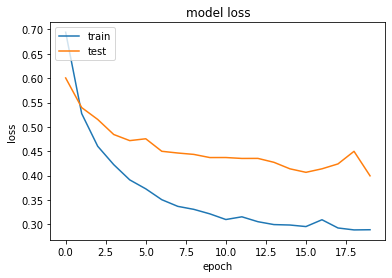

In [84]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

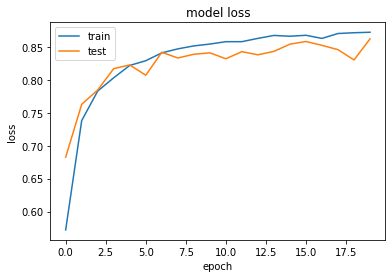

In [85]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [72]:
# Test the model
results = model.evaluate([X_test1, X_test2], Y_test, batch_size=16)
print('test loss, test acc: ', results)

5000/5000 [==============================] - 13s 3ms/sample - loss: 0.3936 - accuracy: 0.8646
test loss, test acc:  [0.3935581598520279, 0.8646]


In [73]:
# Set the model's name
model_name = '0.1.45_Softmax-LSTM-128_batch_20_epochs'

In [74]:
# Save the model
save_model(model, model_name)

## Manual Testing
Converts titles into embeddings arrays and allow the model to make a prediction

In [268]:
model.load_weights('models/' + model_name + '.h5')

In [269]:
title_one = 'corsair 16 gb ram'
title_two = 'cosair rgb 16 gb ram'
#title_one = '16 gb'
#title_two = '16 gb'
title_one_arr = [' '] * MAX_LEN
title_two_arr = [' '] * MAX_LEN
title_one = remove_stop_words(title_one.lower())
title_two = remove_stop_words(title_two.lower())

for idx, x in enumerate(title_one.split(' ')):
    title_one_arr[idx] = x

for idx, x in enumerate(title_two.split(' ')):
    title_two_arr[idx] = x

title_one_arr = np.array(title_one_arr).reshape(1, 45).astype('<U22')
title_two_arr = np.array(title_two_arr).reshape(1, 45).astype('<U22')
print(title_two_arr)

[['cosair' 'rgb' '16' 'gb' 'ram' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '
  ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '
  ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']]


In [270]:
model.predict(x=[title_one_arr, title_two_arr])

array([[0.7467606 , 0.25323948]], dtype=float32)

In [147]:
(Y_train == [1, 0]).sum()

96344

In [150]:
(Y_train == 1).sum()

48064

In [151]:
(Y_train == 0).sum()

48172

In [170]:
title_two_arr.astype('<U22')

array([['2020', 'dell', 'xps', '13', '3', 'ultrabook', 'intel', 'core',
        'i5', '10230u', 'hd', 'webcam', '16gb', 'ram', '512gb', 'pcie',
        'ssd', 'backlit', 'windows', '10', 'silver', ' ', ' ', ' ', ' ',
        ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',
        ' ', ' ', ' ', ' ', ' ', ' ', ' ']], dtype='<U22')

In [196]:
X_train2[555]

array(['802', '11ac', 'premium', 'ideapad', 'ips', 'panel', 'retina',
       'display', '2304x1440', '11', '3', 'core', 'i5', '7400', '96',
       'gb', 'ram', '408', 'gb', 'm', '2', 'ssd', 'usb', 'type', 'c',
       'hdmi', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',
       ' ', ' ', ' ', ' ', ' ', ' ', ' '], dtype='<U22')

In [197]:
X_train1[555]

array(['intel', 'core', 'i5', '7400', '408', 'gb', 'solid', 'state',
       'drive', 'fast', '96', 'gb', '11', '3', 'lenovo', 'ideapad', 'ips',
       'panel', 'retina', 'display', '2304x1440', 'fp', 'reader', '802',
       '11ac', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',
       ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '], dtype='<U22')

In [198]:
Y_train[555]

1